![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Estimating optimal growth periods based on temperatures in seasonal subdaily forecast

Production date: 25.09.2025

Produced by: Johanna Tjernström, Johannes Langvatn

## 🌍 Use case: Investigation of diurnal temperature ranges, and mimimun and maximum temperature in relation to crop growth

## ❓ Quality assessment question
* **Can seasonal forecasts of minimum and maximum temperature be used to draw conclusions about growth conditions for common crops?**

**‘Context paragraph’ (no title/heading)** - a very short introduction before the assessment statement describing approach taken to answer the user question. One or two key references could be useful,  if the assessment summarises literature . These can be referenced directly in the text, like `[Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2)` giving: [Rodriguez et. al. 2018](https://doi.org/10.1038/s41598-018-20628-2). For major references numerical labels like this should be used (which should also listed at the end) `Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2))`giving: Rodriguez et. al. 2018, [[1]](https://doi.org/10.1038/s41598-018-20628-2)). Please use DOI links where possible.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* To be found
```

## 📋 Methodology

A ‘free text’ introduction to the data analysis steps or a description of the literature synthesis, with a justification of the approach taken, and limitations mentioned. **Mention which CDS catalogue entry is used, including a link, and also any other entries used for the assessment**.

Followed by a numbered list of the methodology and results, with the same headings as the sections under ‘Analysis and Results’. These should be links to the sections below, using the format `[](section-label)`. The title of the section will be automatically populated, so no need to repeat the title of the section when referecing it like this.

```{note}
The section labels for the links need to be manually set, as seen below (`(section-1)=`, followed by the heading). These labels will be shown in GitHub but will not appear when the Jupyter Book page is built.
```

* These headings can be specific to the quality assessment, and help guide the user through the ‘story’ of the assessment. This means we cannot pre-define the sections and headings here, as they will be different for each assessment.
* Sub-bullets could be used to outline what will be done/shown/discussed in each section
* The list below is just an example, or may need more or fewer sections, with different headings

E.g. 'The analysis and results are organised in the following steps, which are detailed in the sections below:' 

**[](seasonal_seasonal-original-single-levels_resolution_q08:section-1)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](seasonal_seasonal-original-single-levels_resolution_q08:section-2)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](seasonal_seasonal-original-single-levels_resolution_q08:section-3)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

## 📈 Analysis and results

(seasonal_seasonal-original-single-levels_resolution_q08:section-1)=
### 1. Download data and select region and crop of interest

#### Subsections
Describe what is done in this step/section and what the `code` in the cell does (**if code is included** - some assessment may review literature or reports like PQARs for ECVs, in which case, a markdown file could be provided instead). Note that some details may be better placed in code comments, rather than in the text above the code cell, to help the flow of the Notebook.

**Code:**

* Cell output should be cleaned up as needed (right click the cell after it has run and delete the output if needed), this can also be done with the `'hide-output'` cell tag, added under 'Common Tools -> Cell Tags' on the right in Jupyter Lab (under the cog icon).
* Please consider when cell output would be useful to include, such as printing the summary of the xarray data cube, or an example image. 
* Please link to any non-standard libraries in the references, including the functions from B-Open (a standard line on this is included in the references section).
* The code cells will be adjusted to be 'collapsed by default' when the Jupyter Book page is built.

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
import pandas as pd
import matplotlib.dates as mdates

In [2]:
start_hour = 0
days = 215
leadtime_hour = []
for day in range(days):
    start_hour += 24
    leadtime_hour.append(start_hour)

In [3]:
collection_id_max_min = "seasonal-original-single-levels"
request_max_min = {
    "originating_centre": "ecmwf",
    "system": "51",
    "variable": [
        "maximum_2m_temperature_in_the_last_24_hours",
        "minimum_2m_temperature_in_the_last_24_hours"
    ],
    "year": ["2025"],
    "month": ["03"],
    "day": ["01"],
    "leadtime_hour": leadtime_hour,
    "data_format": "grib"
}

kwargs = {
    "chunks": {"leadtime_hour": 24},
    "n_jobs": 1,
    "backend_kwargs": {"time_dims": ["valid_time"]},
}

da_max_min = download.download_and_transform(
    collection_id_max_min,
    request_max_min,
    **kwargs,
)


#Mean daily temperature for optimum growth and tillering is between 15 and 20°C. 
#specially suceptible to springtime frost
#Mean daily temperatures of less than 10 to 12°C during the growing season make wheat a hazardous crop.
#growing takes about 100 to 130 days
#planting for regions 35 - 45°L in April/May
max_growing_temp = 20
min_growing_temp = 15
hazard_max = 12
hazard_min = 10
plant_month = pd.Timestamp("2025-04-01")#april
growth_time = pd.Timedelta(130,"D")
end_month = plant_month + growth_time
done_month = 0

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]
/data/common/miniforge3/envs/wp3/lib/python3.12/site-packages/earthkit/data/utils/kwargs.py:59: UserWarning: In xarray_open_dataset_kwargs backend_kwargs, overriding the default value (squeeze=False) with squeeze=True is not recommended.
  warnings.warn(


In [4]:
tas_max = da_max_min["mx2t24"]
tas_min = da_max_min["mn2t24"]

In [5]:
slice_europe_max = tas_max.isel(latitude=slice(35,45),longitude=slice(0,40))
slice_europe_min = tas_min.isel(latitude=slice(35,45),longitude=slice(0,40))

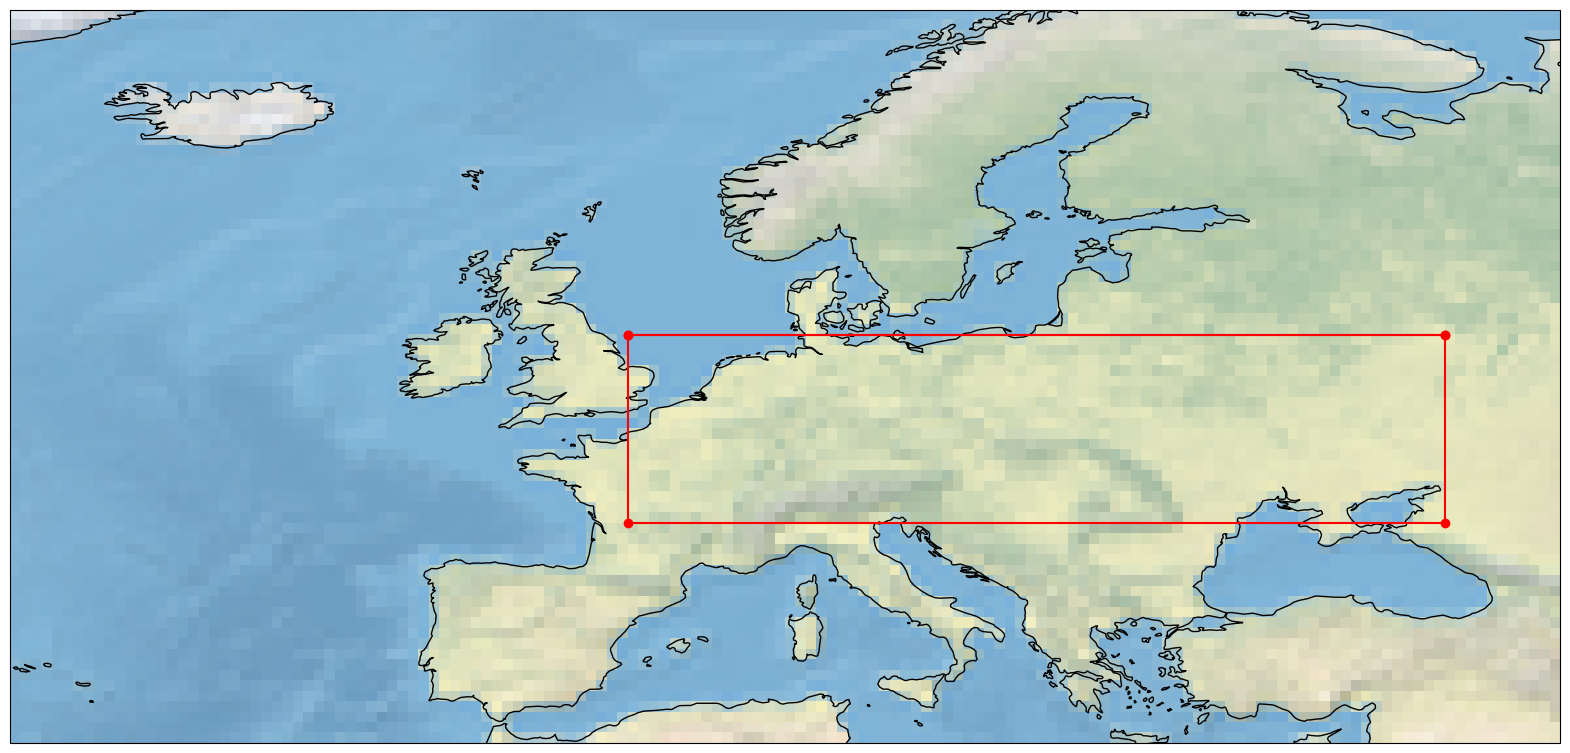

In [6]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.set_extent([-29, 45, 35, 70],crs=ccrs.PlateCarree())
longitudes = [slice_europe_max.longitude[0],slice_europe_max.longitude[-1],slice_europe_max.longitude[-1],slice_europe_max.longitude[0],slice_europe_max.longitude[0],slice_europe_max.longitude[-1]]
latitidues = [slice_europe_max.latitude[0],slice_europe_max.latitude[0],slice_europe_max.latitude[-1],slice_europe_max.latitude[-1], slice_europe_max.latitude[-0],slice_europe_max.latitude[0]]
ax.plot(longitudes, latitidues, marker='o', color='red', transform=ccrs.PlateCarree());

(seasonal_seasonal-original-single-levels_resolution_q08:section-2)=
### 2. Plot the temperature data with growth season and optimal temperature window

Computing the area max, min, mean and standard deviation.

In [7]:
area_mean_max = diagnostics.spatial_weighted_mean(slice_europe_max)
area_mean_min = diagnostics.spatial_weighted_mean(slice_europe_min)

area_std_max = np.std(area_mean_max,axis=0)
area_std_min = np.std(area_mean_min,axis=0)

area_mean_max = area_mean_max.mean("realization")
area_mean_min = area_mean_min.mean("realization")

Plotting the maximum and minimum temperatures against the growth season and optimal temperature window for the chosen crop.

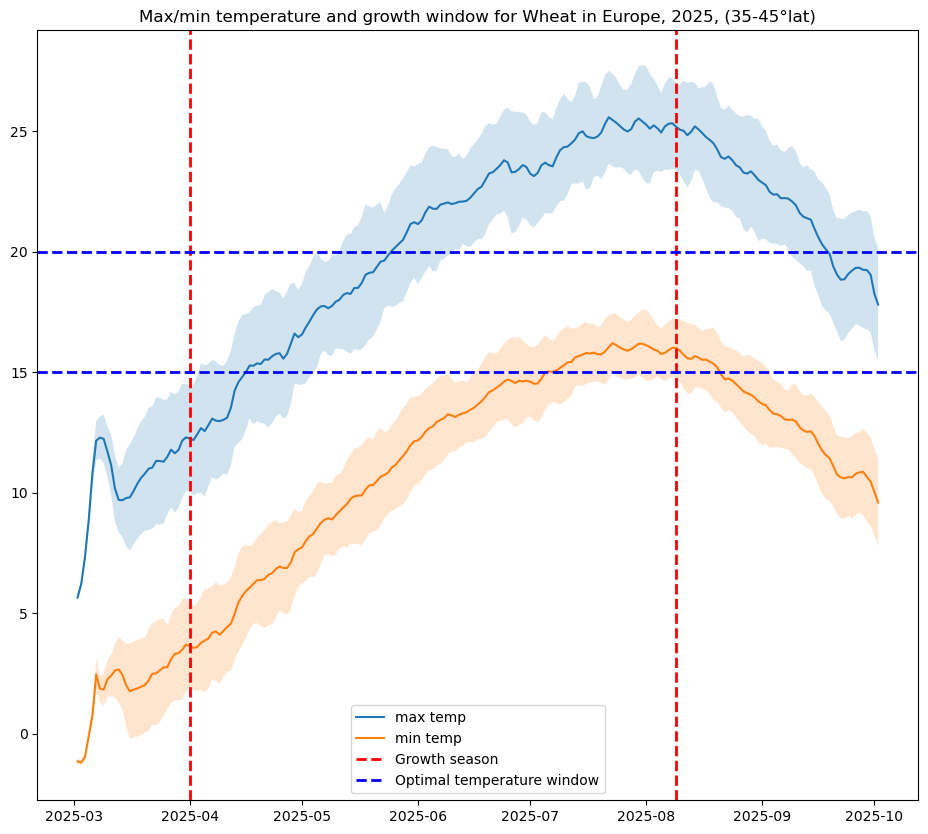

In [8]:
fig = plt.figure(figsize=(25,10))
ax1 = plt.subplot(1,2,1)
convert = lambda x: x-272.15

ax1.plot(area_mean_max.time,area_mean_max-272.15,label="max temp")
ax1.fill_between(area_mean_max.time, area_mean_max-272.15 - area_std_max,area_mean_max-272.15 + area_std_max , alpha=0.2)
ax1.plot(area_mean_min.time,area_mean_min-272.15,label="min temp")
ax1.fill_between(area_mean_min.time, area_mean_min-272.15 - area_std_min,area_mean_min-272.15 + area_std_min , alpha=0.2)


ax1.axvline(x=plant_month, color='red', linestyle='--', linewidth=2,label="Growth season")
ax1.axvline(x=end_month, color='red', linestyle='--', linewidth=2)
ax1.axhline(y=max_growing_temp, color='blue', linestyle='--', linewidth=2, label = "Optimal temperature window")
ax1.axhline(y=min_growing_temp, color='blue', linestyle='--', linewidth=2)
plt.title("Max/min temperature and growth window for Wheat in Europe, 2025, (35-45°lat)")
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%'))

ax1.legend();

(seasonal_seasonal-original-single-levels_resolution_q08:section-3)=
### 3. Investigation of spring frost

Here we will investigate if seasonal forecasts can be used to prevent sowing before occurence of frost. **TODO**

In [9]:
# collapsable code cells

# code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assessment as they wish

In [10]:
# collapsable code cell

# code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assessment as they wish

## ℹ️ If you want to know more

### Key resources

 * Seasonal forecast daily and subdaily data on single levels: [10.24381/cds.181d637e](https://doi.org/10.24381/cds.181d637e)

### Code libraries used:
 * [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
 * xarray
 * numpy
 * matplotlib
 * pandas

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.